In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pypsa
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import seaborn as sns
import numpy as np
import cartopy.feature as cfeature
plt.style.use('ggplot')
%matplotlib inline

In [2]:
regions = gpd.read_file("../input/regions_onshore_elec_s_256.geojson")

<Axes: >

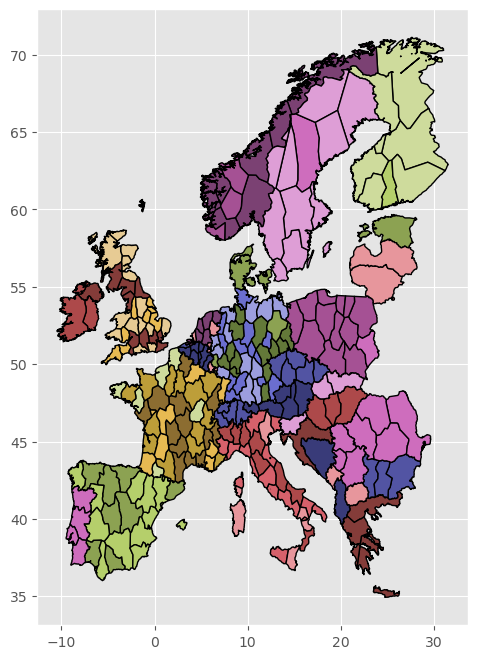

In [5]:
regions.plot(figsize=(8, 8), column="name", cmap="tab20b", linewidth=1, edgecolor="k")

In [6]:
n = pypsa.Network("../input/elec_s_256_ec.nc")

INFO:pypsa.io:Imported network elec_s_256_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [17]:
n.generators_t.p_max_pu.filter(like="onwind").T

snapshot,2013-01-01 00:00:00,2013-01-01 01:00:00,2013-01-01 02:00:00,2013-01-01 03:00:00,2013-01-01 04:00:00,2013-01-01 05:00:00,2013-01-01 06:00:00,2013-01-01 07:00:00,2013-01-01 08:00:00,2013-01-01 09:00:00,...,2013-12-31 14:00:00,2013-12-31 15:00:00,2013-12-31 16:00:00,2013-12-31 17:00:00,2013-12-31 18:00:00,2013-12-31 19:00:00,2013-12-31 20:00:00,2013-12-31 21:00:00,2013-12-31 22:00:00,2013-12-31 23:00:00
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 onwind,0.001468,0.000000,0.000000,0.000000,0.000000,0.001736,0.003049,0.003906,0.002842,0.000000,...,0.005387,0.004838,0.005517,0.008730,0.015415,0.024328,0.031360,0.034518,0.027423,0.020763
AT1 0 onwind,0.038134,0.035119,0.028920,0.024281,0.024787,0.024882,0.021864,0.018648,0.013658,0.013802,...,0.000581,0.000553,0.000442,0.000691,0.001699,0.004933,0.005833,0.006273,0.022262,0.023524
AT1 1 onwind,0.250913,0.266881,0.271937,0.272902,0.256804,0.227552,0.208295,0.197852,0.163520,0.113406,...,0.073039,0.084667,0.093855,0.114928,0.139729,0.157616,0.172894,0.185978,0.188884,0.204211
AT1 2 onwind,0.035698,0.030655,0.023057,0.021747,0.021538,0.018601,0.014484,0.012150,0.011543,0.013804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028253,0.025541
AT1 3 onwind,0.017263,0.009003,0.001008,0.001622,0.001625,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.004331,0.017875,0.025113,0.032283,0.044464,0.055535,0.050864,0.031451,0.001615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE2 8 onwind,0.212225,0.204801,0.196035,0.169656,0.139653,0.091723,0.066219,0.044968,0.041963,0.035737,...,0.284259,0.273525,0.218370,0.180166,0.181587,0.213867,0.236366,0.182020,0.111334,0.066998
SE2 9 onwind,0.639028,0.649846,0.656057,0.657156,0.723332,0.746097,0.750343,0.705394,0.687429,0.679517,...,0.873006,0.905241,0.915372,0.911034,0.901131,0.869099,0.803584,0.704380,0.664744,0.580627
SI1 0 onwind,0.059446,0.057114,0.057187,0.056043,0.052521,0.053093,0.054690,0.066748,0.076862,0.082403,...,0.002470,0.003285,0.002501,0.002090,0.002125,0.002033,0.000000,0.005831,0.007808,0.011435


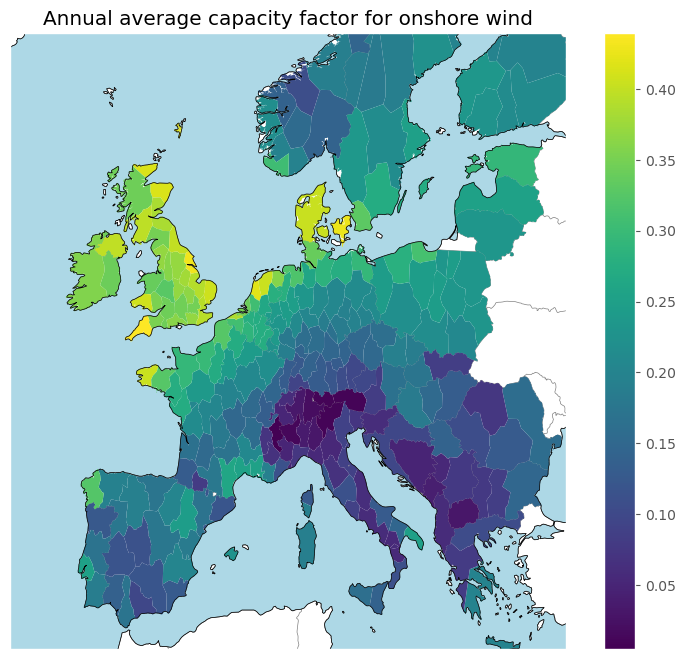

In [69]:
def plot_average_capacity_factor(regions, network, carrier):

    if carrier == "onwind":
        colormap = "viridis"
    if carrier == "solar":
        colormap = "cividis"

    # Extract time series of specified carrier feed-in per region and calculate average
    carrier_data = network.generators_t.p_max_pu.filter(like=carrier).mean()

    # Adjust the renaming to include the full region and sub-region code
    capacity_factors = carrier_data.rename(lambda x: " ".join(x.split()[:-1])).to_frame(
        "average_capacity_factor"
    )

    # Merge using the updated keys
    regions = regions.merge(
        capacity_factors, left_on="name", right_index=True, how="left"
    )

    fig, ax = plt.subplots(
        subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 8)
    )
    ax.set_extent([-15, 30, 35, 65], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    regions.plot(column="average_capacity_factor", ax=ax, legend=True, cmap=colormap)

    if carrier == "onwind":
        _ = "onshore wind"
    if carrier == "solar":
        _ = "solar PV"

    ax.coastlines()
    ax.set_title(f"Annual average capacity factor for {_}")
    plt.show()


plot_average_capacity_factor(regions, n, "onwind")

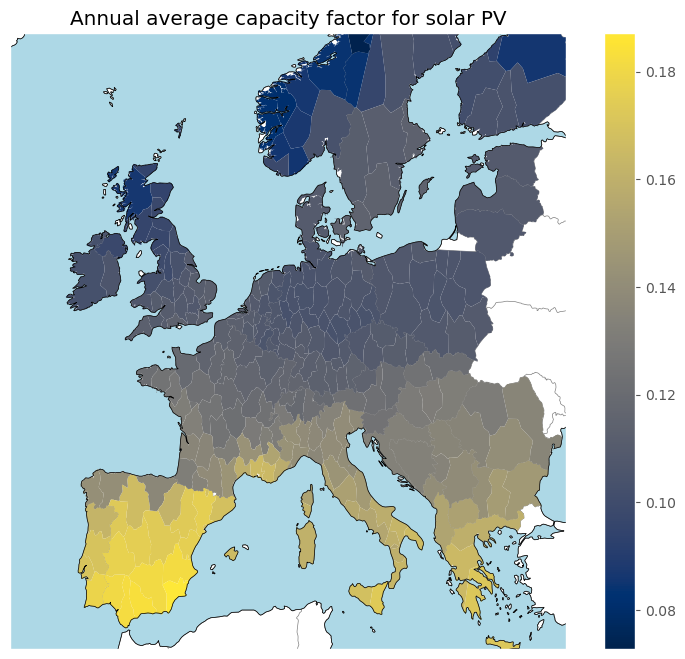

In [70]:
plot_average_capacity_factor(regions, n, "solar")

In [126]:
def compute_pearson_correlation_falloff(network, carrier, base_region):
    """
    Computes the Pearson correlation coefficient between the p_max_pu time series
    of a specified base region for a given carrier and all other regions.

    Returns:
    - A DataFrame with each region and its correlation coefficient with the base region.
    """

    feedin = network.generators_t.p_max_pu.filter(like=carrier)

    base_series = feedin[f"{base_region} {carrier}"]

    correlations = []
    for region in feedin.columns:

        other_series = feedin[region]
        correlation = base_series.corr(other_series)

        region_name = " ".join(region.split()[:-1])
        correlations.append((region_name, correlation))

    correlation_df = pd.DataFrame(correlations, columns=["Region", "Correlation"])
    return correlation_df.sort_values("Correlation", ascending=False)


correlation_df = compute_pearson_correlation_falloff(n, "onwind", "IT1 0")
print(correlation_df)

     Region  Correlation
171   IT1 0     1.000000
179  IT1 16     0.810411
192   IT1 7     0.718296
181  IT1 18     0.717660
6     BA1 0     0.655783
..      ...          ...
155   GB0 4    -0.054775
247   SE2 4    -0.068751
212   NO2 2    -0.080673
252   SE2 9    -0.091176
216   NO2 6    -0.111355

[256 rows x 2 columns]


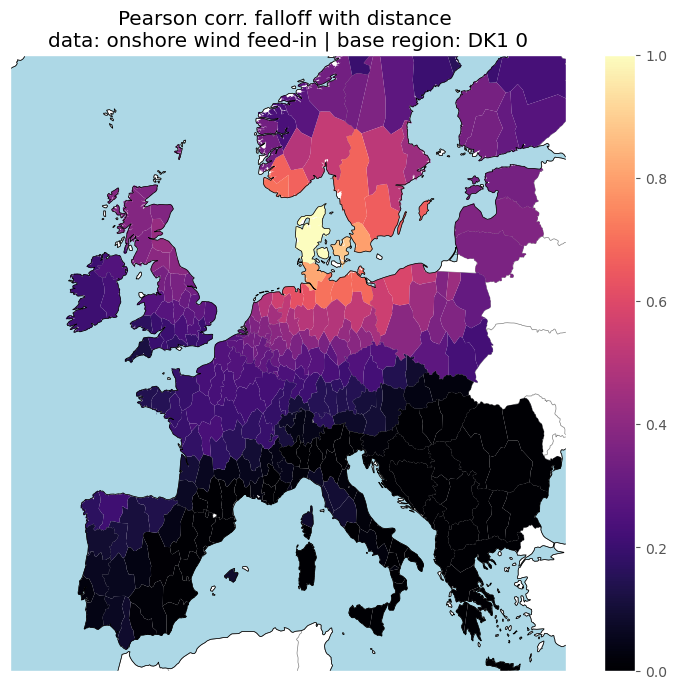

In [150]:
def plot_pearson_falloff(
    regions, network, carrier="onwind", base_region="DK1 0", colormap="viridis"
):

    data = compute_pearson_correlation_falloff(n, carrier, base_region)

    merged_data = regions.merge(data, left_on="name", right_on="Region", how="left")

    fig, ax = plt.subplots(
        subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 8)
    )
    ax.set_extent([-15, 30, 35, 65], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    merged_data.plot(
        column="Correlation", ax=ax, legend=True, cmap=colormap, vmin=0, vmax=1
    )

    if carrier == "onwind":
        _ = "onshore wind"
    if carrier == "solar":
        _ = "solar PV"

    ax.coastlines()
    ax.set_title(
        f"Pearson corr. falloff with distance \n"
        f"data: {_} feed-in | base region: {base_region}"
    )

    # plt.show()
    plt.savefig(
        f"../manuscript/img/pearson_corr_falloff_{carrier}_{base_region}.pdf",
        bbox_inches="tight",
    )


plot_pearson_falloff(
    regions, n, carrier="onwind", base_region="DK1 0", colormap="magma"
)

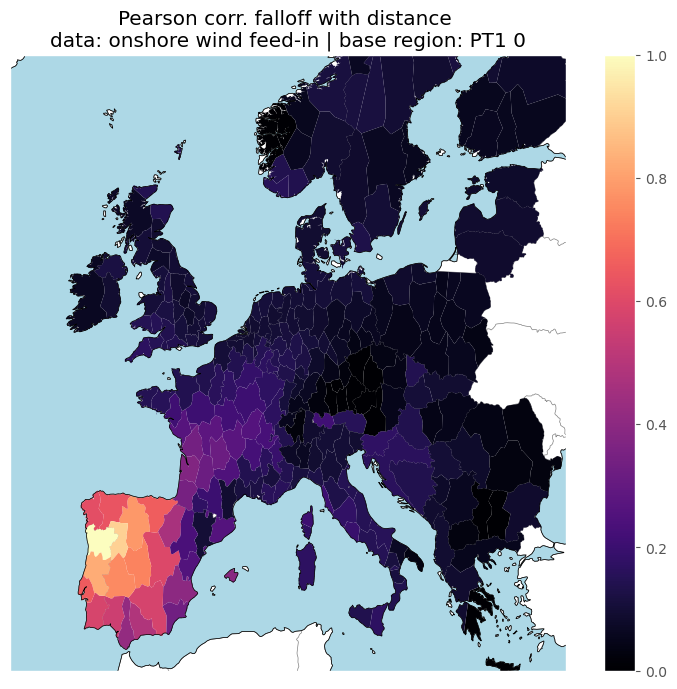

In [151]:
plot_pearson_falloff(
    regions, n, carrier="onwind", base_region="PT1 0", colormap="magma"
)

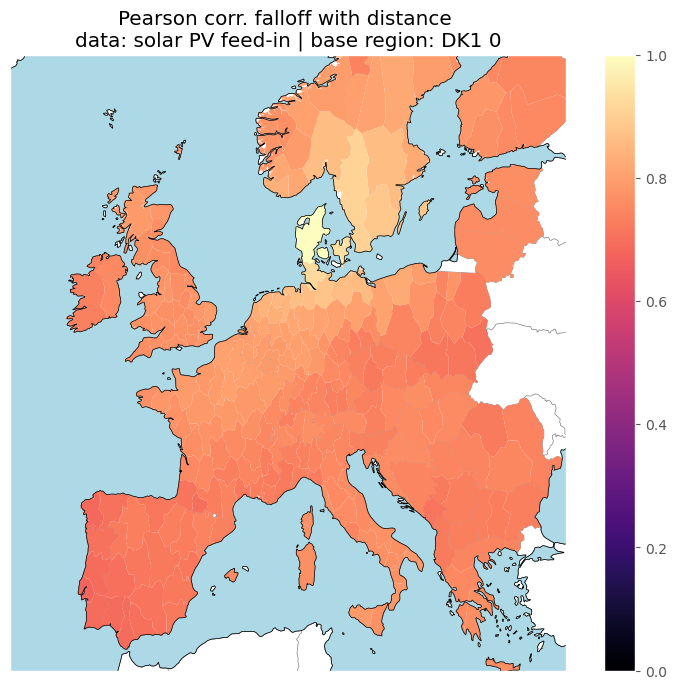

In [152]:
plot_pearson_falloff(regions, n, carrier="solar", base_region="DK1 0", colormap="magma")